In [ ]:
# Please note that DR(distribution rate) was previously referred to as ER(entanglement rate)
import numpy as np
import json

import tqdm as tqdm

from simplequantnetsim.protocols import MPC_protocol, MPG_protocol, SP_protocol
from simplequantnetsim.graph import network, set_edge_length, update_graph_params, set_p_edge
from simplequantnetsim.graph_manager import load_from_file
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
mkr = ["x", "+", "d", "o", "1", "2"] + ["x"] * 100
dashs = ["-.", "--", ":", "-"] + ["-"] * 100
cols = ["gray", "g", "b", "orange", "r", "k", "purple"] + ["k"] * 100
linewidth = 2.2
mks = 5.5
fontsize = 14

# DR against operation for the MPC, MPG, and SP protocols

In [3]:
Mesh_topologies = "UKnet.txt" # "ARPAnet_distancia_MTBF_MTTR.txt", "EON_distancia_MTBF_MTTR.txt", "Eurocore.txt", "NSFnet.txt". "UKnet.txt". "USnet.txt"
# center = (size - 1) / 2
G = load_from_file(Mesh_topologies) # G = network(size, size)
nodes = list(G.nodes)
protocols = [MPC_protocol, MPG_protocol, SP_protocol]

In [4]:
# 计算接近中心性
closeness_centralities = nx.closeness_centrality(G)

# 将节点按接近中心性高低排序
sorted_closeness_centralities = sorted(closeness_centralities.items(), key=lambda item: item[1], reverse=True)

# 输出排序后的节点和其接近中心性
for node, centrality in sorted_closeness_centralities:
    print(f"Node {node}: {centrality}")

Node 8: 0.5555555555555556
Node 7: 0.5128205128205128
Node 0: 0.4878048780487805
Node 19: 0.47619047619047616
Node 13: 0.45454545454545453
Node 6: 0.45454545454545453
Node 14: 0.45454545454545453
Node 5: 0.425531914893617
Node 20: 0.425531914893617
Node 3: 0.4166666666666667
Node 9: 0.4166666666666667
Node 10: 0.40816326530612246
Node 2: 0.4
Node 15: 0.4
Node 12: 0.36363636363636365
Node 1: 0.3508771929824561
Node 16: 0.3448275862068966
Node 18: 0.32786885245901637
Node 4: 0.31746031746031744
Node 11: 0.3125
Node 17: 0.3076923076923077


In [5]:
p_op_range = np.linspace(1.0, 0.1, 30) # length_range = np.linspace(0, 30, 30) # probability of imperfect operations
ER = np.zeros((len(protocols), len(p_op_range)))
timesteps = 1000
reps = 200
Q_c = 1
# length = 1
loss_dB = 0.2

update_graph_params(G, Qc=Q_c)

users = [
    '8',
    '7',
    '0',
    '19',
    '13',
]  # "source" for SP & MPG will be the central node

for i, p_op in enumerate(tqdm.tqdm(p_op_range)):  # tqdm_notebook
    set_p_edge(G, p_op, loss_dB=loss_dB) # set_edge_length(G, length=length, p_op=p_op, loss_dB=loss_dB)
    for j, function in enumerate(protocols):
        # if (
        #     (length > 160)
        #     # or (length > 160 and function == MPG_protocol)
        #     # or (length > 160 and function == SP_protocol)
        # ):
        #     ER[j, i] += 0
        #     break
        er, multipartite_gen_time, links_used = function(G, users, timesteps=timesteps, reps=reps)
        ER[j, i] += er

  0%|          | 0/30 [00:00<?, ?it/s]e:\books\research project\code\quantum_repeaters-main\simplequantnetsim\protocols.py:118: FutureWarning: steiner_tree will change default method from 'kou' to 'mehlhorn'in version 3.2.
Set the `method` kwarg to remove this warning.
  K = steiner_tree(
e:\books\research project\code\quantum_repeaters-main\simplequantnetsim\protocols.py:95: FutureWarning: steiner_tree will change default method from 'kou' to 'mehlhorn'in version 3.2.
Set the `method` kwarg to remove this warning.
  success = success_protocol(G, H, users, used_nodes, count_fusion)  # protocol specific
100%|██████████| 30/30 [04:39<00:00,  9.31s/it]


## Plot figure

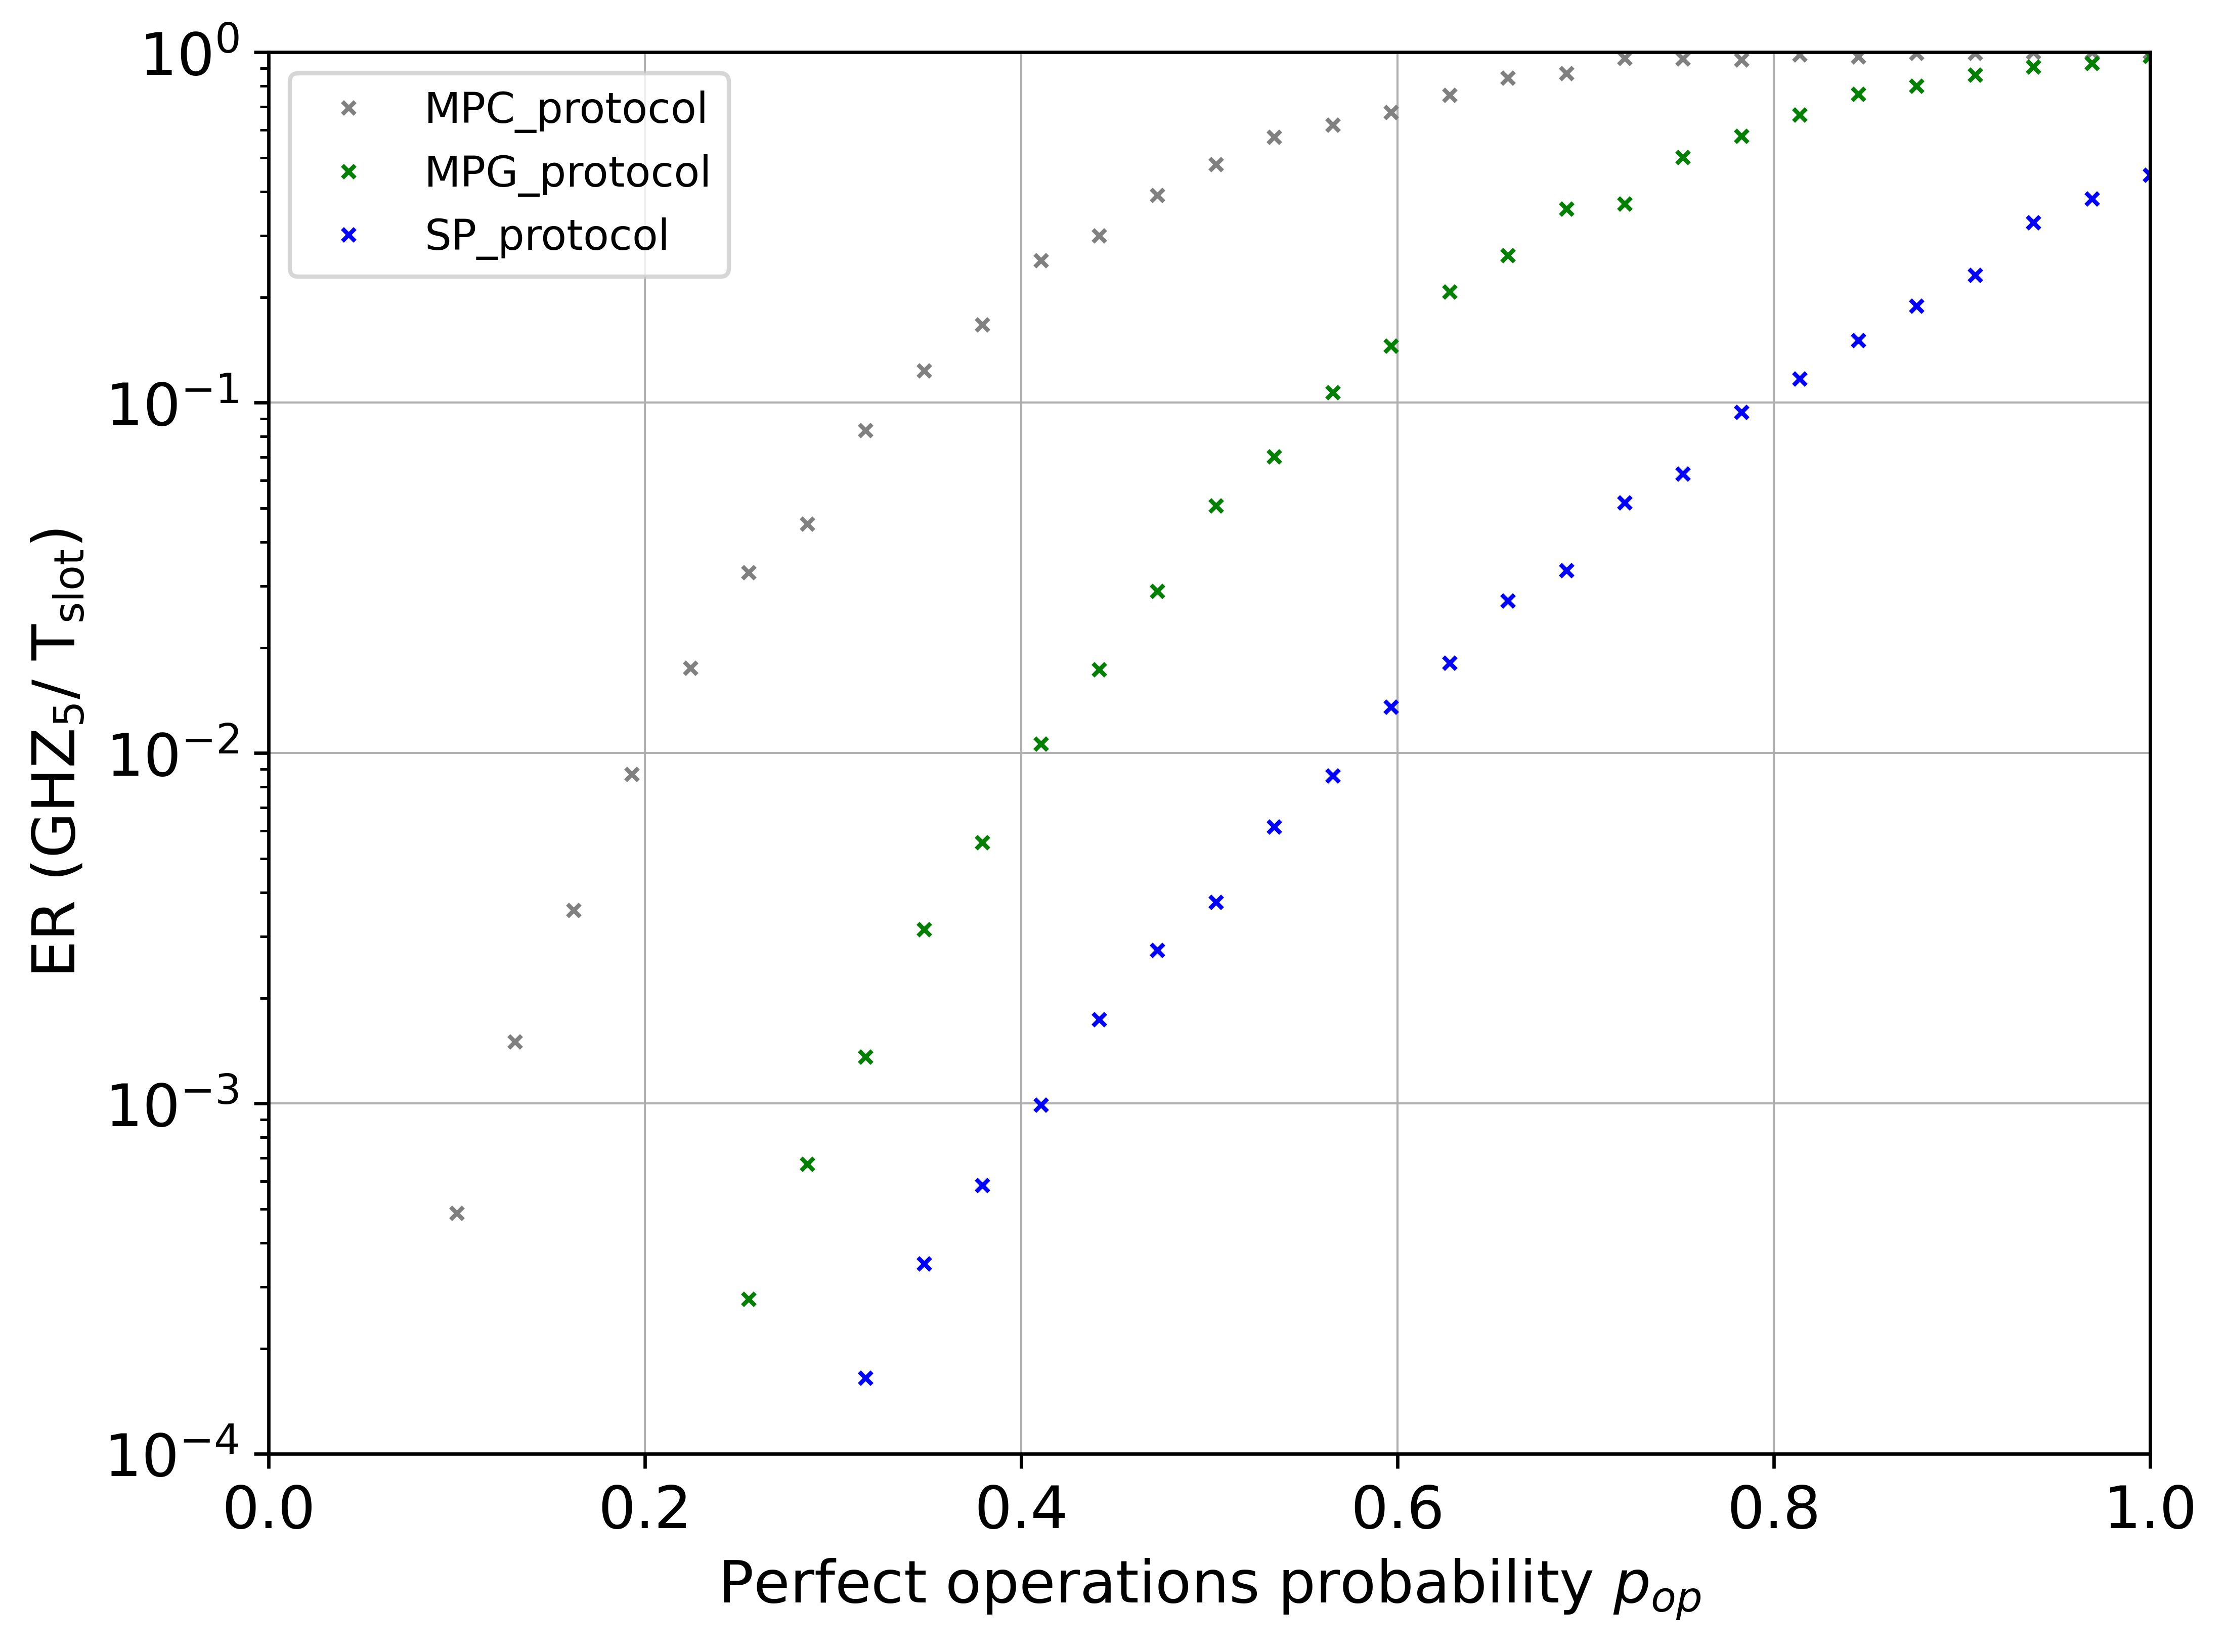

In [6]:
nom_list = [str(p).split(" ")[1] for p in protocols]
plt.figure(figsize=(8, 6), dpi=600)
plt.grid(linewidth=0.5)
for i in range(len(protocols)):
    y = plt.plot(
        p_op_range,
        ER[i],
        color=cols[i],
        marker="x",
        linestyle="None",
        markersize=3,
        #  alpha = 0.5,
        #  linewidth=linewidth,
        label=nom_list[i],
    )
plt.yscale("log")
plt.legend(fontsize=10)
plt.tick_params(labelsize=fontsize)

plt.xlabel("Perfect operations probability $p_{op}$", fontsize=fontsize)
plt.ylabel("DR ($\mathregular{GHZ}_5/\ \\mathregular{T_{slot}}$)", fontsize=fontsize)

ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0.0001, 1])

plt.savefig("figures_HS/DR_v_operation.png", dpi=600)

## Save data

In [9]:
data_to_save = {
    "Mesh_topologies": Mesh_topologies,
    "Q_c": Q_c,
    "loss_dB": loss_dB,
    "datapoints": p_op_range.size,
    "timesteps": timesteps,
    "reps": reps,
    "users": users,
    "protocols": nom_list,
    "p_op_range": p_op_range.tolist(),
    "ER": ER.tolist(),
}

filename = "DR_p_op/UK/Q1"

with open("data_HS/" + filename + ".json", "w") as file:
    file.write(json.dumps(data_to_save))

## Load and plot data

In [10]:
file_to_open = "DR_p_op/UK/Q1"
with open("data_HS/" + file_to_open + ".json", "r") as file:
    loaded_data = json.loads(file.read())

# files_to_open = ["5x5/p_op1/Q1_range30", "9x9/Q1", "15x15/Q1", "25x25/Q1"]
# for i, file_name in enumerate(files_to_open):
#     with open("data/ER_len/" + file_name + ".json", "r") as file:
#         loaded_data[i] = json.loads(file.read())

# reduce points
# loaded_data['length_range'][::2]

In [11]:
# def length2p_ph(l):
#     return 10 ** -(loaded_data["loss_dB"] * l / 10)

# def p_ph2length(p):
#     return -(np.log10(p) * 10) / loaded_data["loss_dB"]

# length2p_e = lambda l: length2p_ph(l) * loaded_data["p_op"]
# p_e2length = lambda p: p_ph2length(p / loaded_data["p_op"])

# def p_op2p_e(op):
#     return op * p_ph

# def p_e2p_op(e):

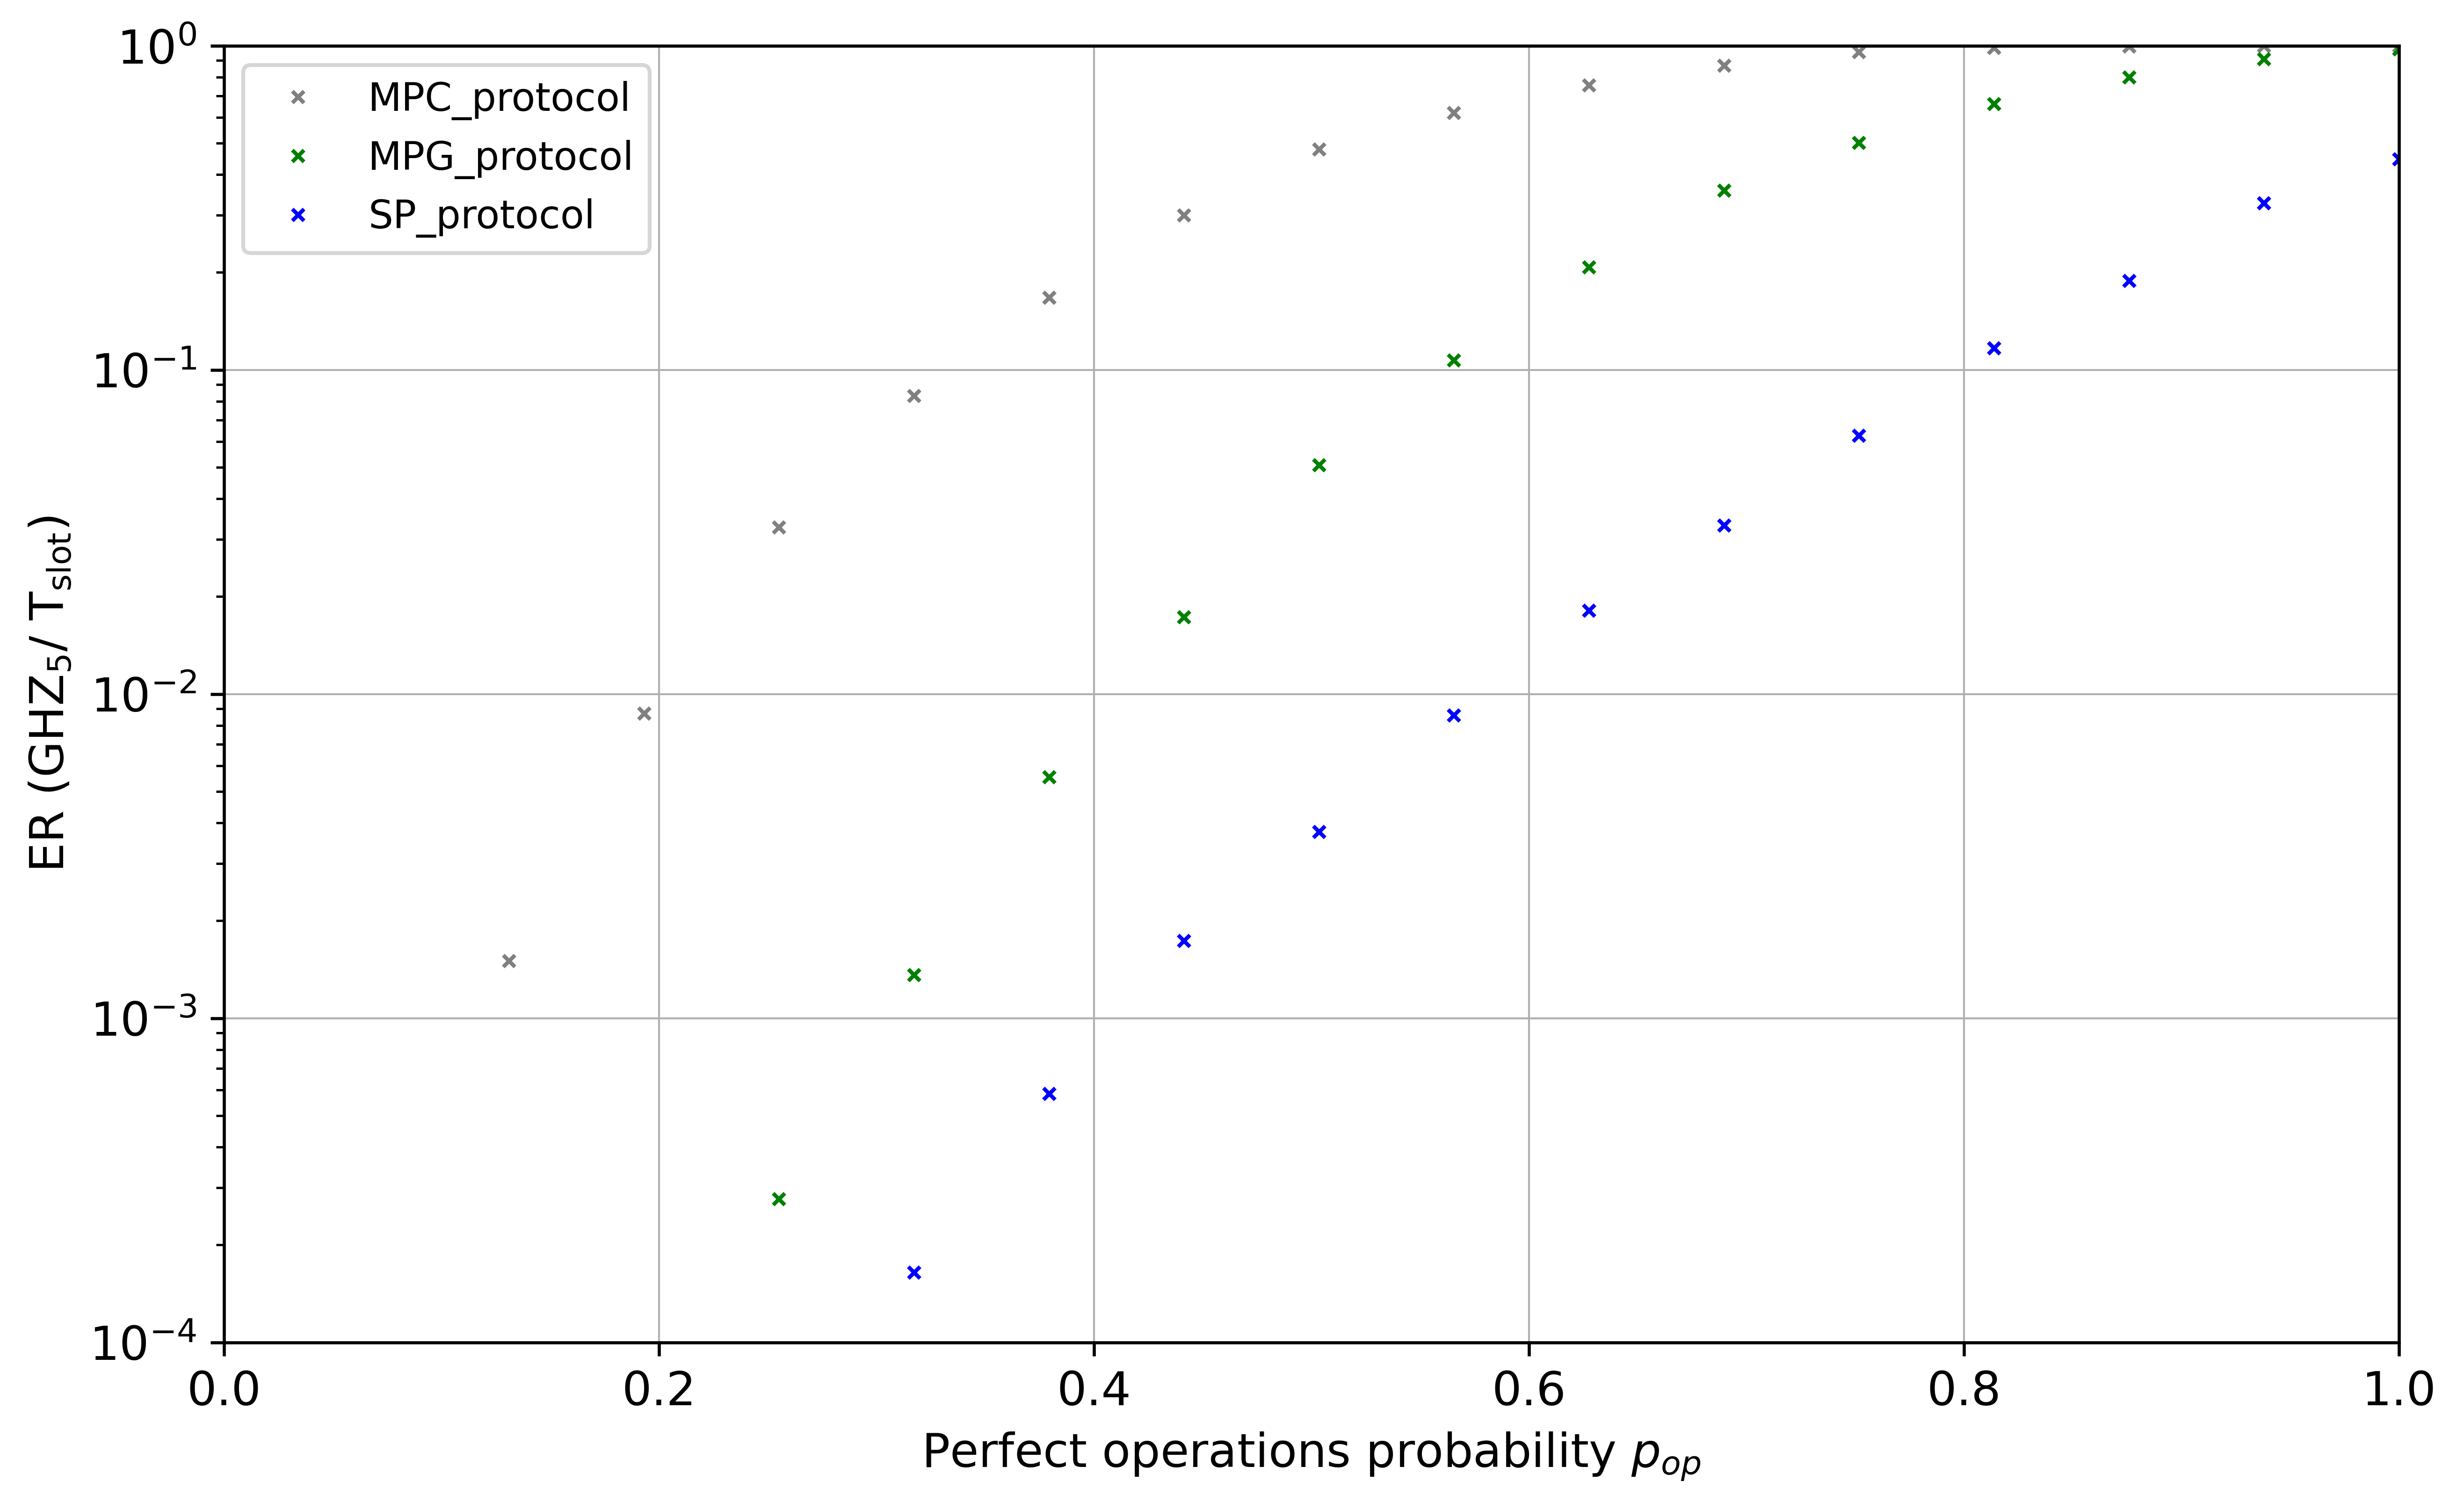

In [12]:
fontsize = 12
# grid_sizes = ["5x5", "9x9", "15x15", "25x25"]
protocol_list = loaded_data["protocols"]
plt.figure(figsize=(10, 6), dpi=600)
plt.grid(linewidth=0.5)
for i in range(len(protocol_list)):
    y = plt.plot(
        loaded_data["p_op_range"][::2],
        loaded_data["ER"][i][::2],
        color=cols[i],
        marker="x",
        linestyle="None",
        markersize=3,
        #  alpha = 0.5,
        #  linewidth=linewidth,
        label=protocol_list[i],
    )

# plot ER=p line
# plt.plot(
#     np.linspace(0, 160, 200),
#     [length2p_e(l) for l in np.linspace(0, 160, 200)],
#     color="black",
#     linestyle="--",
#     linewidth="1",
#     alpha=0.8,
#     label="$\mathregular{p_e}$",
# )

plt.yscale("log")
plt.legend(fontsize=10)
plt.tick_params(labelsize=fontsize)

plt.xlabel("Perfect operations probability $p_{op}$", fontsize=fontsize)
plt.ylabel("DR ($\mathregular{GHZ}_5/\ \\mathregular{T_{slot}}$)", fontsize=fontsize)

ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0.0001, 1])

# ax2 = ax.secondary_xaxis(-0.15, functions=(length2p_ph, p_ph2length))
# ax2.set_xlabel("Photon transmission probability $p_{ph}$", fontsize=fontsize)

# l_ticks = ax.get_xticks()
# p_ph_ticks = length2p_ph(l_ticks)
# ax2.set_xticks(p_ph_ticks)
# ax2.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
# ax2.xaxis.set_tick_params(labelsize=fontsize)

# ax3 = ax.secondary_xaxis(-0.3, functions=(length2p_e, p_e2length))
# ax3.set_xlabel("Entanglement link generation probability $p_e$", fontsize=fontsize)

# p_e_ticks = length2p_e(l_ticks)
# ax3.set_xticks(p_e_ticks)
# ax3.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
# ax3.xaxis.set_tick_params(labelsize=fontsize)

plt.savefig("figures_HS/DR_v_operation2.png", dpi=600, bbox_inches="tight")

# Links used against operation

In [13]:
Mesh_topologies = "UKnet.txt" # "ARPAnet_distancia_MTBF_MTTR.txt", "EON_distancia_MTBF_MTTR.txt", "Eurocore.txt", "NSFnet.txt". "UKnet.txt". "USnet.txt"
G = load_from_file(Mesh_topologies)
nodes = list(G.nodes)
protocols = [MPC_protocol, MPG_protocol, SP_protocol]

In [14]:
p_op_range = np.linspace(0, 1, 200)
links_used = np.zeros((len(protocols), len(p_op_range)))
timesteps = 1000
reps = 200
Q_c = 1
loss_dB = 0.2

update_graph_params(G, Qc=Q_c)

users = [
    '8',
    '7',
    '0',
    '19',
    '13',
]  # "source" for SP & MPG will be the central node

for i, p_op in enumerate(tqdm.tqdm(p_op_range)):  # tqdm_notebook
    set_p_edge(G, p_op, loss_dB=loss_dB)
    for j, function in enumerate(protocols):
        er, multipartite_gen_time, avg_links_used = function(G, users, timesteps=timesteps, reps=reps)
        links_used[j, i] += avg_links_used

  3%|▎         | 6/200 [03:14<1:43:51, 32.12s/it]e:\books\research project\code\quantum_repeaters-main\simplequantnetsim\protocols.py:95: FutureWarning: steiner_tree will change default method from 'kou' to 'mehlhorn'in version 3.2.
Set the `method` kwarg to remove this warning.
  success = success_protocol(G, H, users, used_nodes, count_fusion)  # protocol specific
 16%|█▌        | 31/200 [17:28<1:35:17, 33.83s/it]


KeyboardInterrupt: 

## Save data

In [ ]:
data_to_save = {
    "Mesh_topologies": Mesh_topologies,
    "Q_c": Q_c,
    "loss_dB": loss_dB,
    "datapoints": p_op_range.size,
    "timesteps": timesteps,
    "reps": reps,
    "users": users,
    "protocols": nom_list,
    "p_op_range": p_op_range.tolist(),
    "links_used": links_used.tolist(),
}

filename = "links_p_op/UK/Q1"

with open("data_HS/" + filename + ".json", "w") as file:
    file.write(json.dumps(data_to_save))

## Load and plot data

In [ ]:
file_to_open = "links_p_op/UK/Q1"
with open("data_HS/" + file_to_open + ".json", "r") as file:
    loaded_data = json.loads(file.read())

In [ ]:
# def length2p_ph(l):
#     return 10 ** -(loaded_data["loss_dB"] * l / 10)

# def p_ph2length(p):
#     return -(np.log10(p) * 10) / loaded_data["loss_dB"]

# length2p_e = lambda l: length2p_ph(l) * loaded_data["p_op"]
# p_e2length = lambda p: p_ph2length(p / loaded_data["p_op"])

In [ ]:
fontsize = 12
protocol_list = loaded_data["protocols"]
plt.figure(figsize=(10, 6), dpi=600)
plt.grid(linewidth=0.5)
for i in range(len(protocol_list)):
    y = plt.plot(
        loaded_data["p_op_range"],
        loaded_data["links_used"][i],
        color=cols[i],
        marker="x",
        linestyle="None",
        markersize=3,
        label=protocol_list[i],
    )

# plt.yscale("log")
plt.legend(fontsize=10)
plt.tick_params(labelsize=fontsize)

plt.xlabel("Perfect operations probability $p_{op}$", fontsize=fontsize)
plt.ylabel("Number of links used (/reps)", fontsize=fontsize)

ax = plt.gca()
ax.set_xlim([0, 1])
# ax.set_ylim([0.0001, 1])

# ax2 = ax.secondary_xaxis(-0.15, functions=(length2p_ph, p_ph2length))
# ax2.set_xlabel("Photon transmission probability $p_{ph}$", fontsize=fontsize)

# l_ticks = ax.get_xticks()
# p_ph_ticks = length2p_ph(l_ticks)
# ax2.set_xticks(p_ph_ticks)
# ax2.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
# ax2.xaxis.set_tick_params(labelsize=fontsize)

# ax3 = ax.secondary_xaxis(-0.3, functions=(length2p_e, p_e2length))
# ax3.set_xlabel("Entanglement link generation probability $p_e$", fontsize=fontsize)

# p_e_ticks = length2p_e(l_ticks)
# ax3.set_xticks(p_e_ticks)
# ax3.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
# ax3.xaxis.set_tick_params(labelsize=fontsize)

plt.savefig("figures_HS/links_v_operation.png", dpi=600, bbox_inches="tight")